In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pomegranate.distributions import Normal
from pomegranate.hmm import DenseHMM
import os
import torch
import warnings
import numpy as np
warnings.filterwarnings('ignore')

In [2]:
RETURN_PERCENT_COL = 'returns_percent'
LOG_MA_RETURN_COL = 'log_ma_return'
MA_NUM = 7
MODEL_VERSION = "model_v1"

TRAINING_PERIOD_START = '2003-09-10'
TRAINING_PERIOD_END = '2020-12-31'

#################
## UTILS
#################
def _reshape_feature(feature_df):
    nrows, ncols = feature_df.shape
    return torch.from_numpy(feature_df.to_numpy().reshape((1, nrows, ncols)))

def _reshape_any_input(last_200_closing_prices):
    if type(last_200_closing_prices) == pd.DataFrame:
        return _reshape_feature(last_200_closing_prices)
    
    if type(last_200_closing_prices) == list:
        df = pd.DataFrame(last_200_closing_prices)
        return _reshape_feature(df[[0]])
    
    if type(last_200_closing_prices) == np.ndarray:
        arr_shape = last_200_closing_prices.shape
        return torch.from_numpy(
            last_200_closing_prices.reshape(1, arr_shape[0], 1)
        )
    raise Exception('last_200_closing_prices must be of type list / np.ndarray /  pd.DataFrame')

def _to_series(tensor):
    return tensor.numpy()[0]

def _compute_returns(target_df, ma):
    prices = target_df['close']
    returns = prices.pct_change()
    target_df[RETURN_PERCENT_COL] = 100 * returns
    moving_avg = prices.rolling(ma).mean()
    target_df[LOG_MA_RETURN_COL] = np.log(moving_avg / moving_avg.shift(1))
    target_df = target_df[
        (~target_df[RETURN_PERCENT_COL].isnull()) & 
        (~target_df[LOG_MA_RETURN_COL].isnull())
    ]
    target_df[LOG_MA_RETURN_COL] = (target_df[LOG_MA_RETURN_COL] * 100) + 10
    return target_df

    
def _get_label_color_mapping(plot_df):
    palette = {}
    for key, gp_df in plot_df.groupby('state'):
        score = gp_df[RETURN_PERCENT_COL].mean()
        palette[key] = score
    bear_key = min(palette, key=palette.get)
    bull_key = max(palette, key=palette.get)
    palette[bear_key] = "red"
    palette[bull_key] = "green"
    return palette

#################
## MAIN FUNCTIONS
#################
def get_ticker_data():
    target_df = pd.read_csv("spy.csv").sort_values('datetime', ascending=True) 
    target_df['datetime'] = pd.to_datetime(target_df.datetime)
    target_df.set_index('datetime', inplace=True)
    return _compute_returns(target_df, MA_NUM)

def get_train_test_df(target_df, train_col=LOG_MA_RETURN_COL):
    nrows = target_df.shape[0]
    train_df = target_df.loc[TRAINING_PERIOD_START: TRAINING_PERIOD_END]
    nrows_train = train_df.shape[0]
    test_df = target_df.tail(nrows - nrows_train)
    train_X = _reshape_feature(train_df[[LOG_MA_RETURN_COL]])
    test_X = _reshape_feature(test_df[[LOG_MA_RETURN_COL]])
    return train_df, train_X, test_df, test_X

def train_model(train_X):
    bear_dist = Normal()
    bull_dist = Normal()
    count = 0
    while count < 5:
        try:
            model = DenseHMM(
                distributions=[bear_dist, bull_dist],
                max_iter=10000,
                tol=0.01,
                verbose=False
            )
            return model.fit(train_X)
        except Exception as e:
            count += 1
    raise Exception(f"TRAINING FAILED: {e}")
    
def get_label_mapping(model, train_df, train_X):
    train_df['state'] = _to_series(model.predict(train_X))
    label_color_mapping = _get_label_color_mapping(train_df)
    return label_color_mapping

def predict(model, last_200_closing_prices, label_color_mapping):
    feature_tensor = _reshape_any_input(last_200_closing_prices)
    return [label_color_mapping.get(state) for state in _to_series(model.predict(feature_tensor))]
            
########## 
### DEV
########## 
def plot(plot_df, tail=None):
    fig = plt.figure(figsize=(20, 8))
    if tail:
        plot_df = plot_df.tail(tail)
    ax = sns.scatterplot(
        x=plot_df.index, 
        y=plot_df['close'],
        palette={"red": "red", "green": "green"},
        hue=plot_df['state']        
    )
    ax.legend_.remove()
    plt.xlabel('Time')
    plt.ylabel('Close Price')       

In [3]:
target_df = get_ticker_data()
train_df, train_X, test_df, test_X = get_train_test_df(target_df)
model = train_model(train_X)
label_color_mapping = get_label_mapping(model, train_df, train_X)

In [4]:
target_df.index.min(), target_df.index.max()

(Timestamp('2003-09-19 00:00:00'), Timestamp('2024-07-08 00:00:00'))

In [5]:
test_df = target_df.loc['2023-01-01': '2024-07-08']
last_n_closing_prices = test_df[[LOG_MA_RETURN_COL]]

In [6]:
test_state = predict(model, last_n_closing_prices, label_color_mapping)
test_df['state'] = test_state
print(test_state[-1])

green


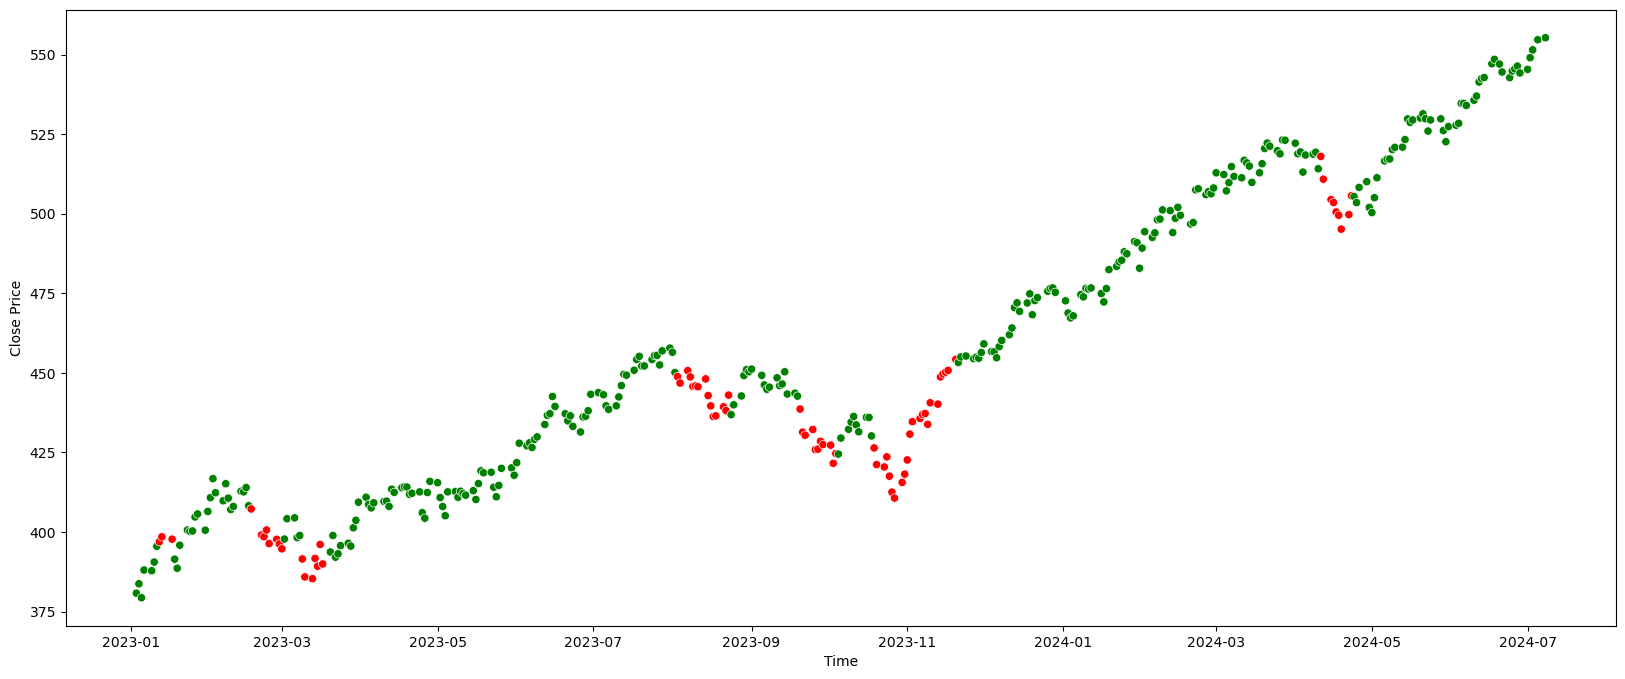

In [7]:
plot(test_df)